This code propagates a satellite in terms of slight variations in its initial orbital parameters, and stops the propagation when the satellite reaches 80km of altitude. The code then translates the initial Gaussian standard deviation into new uncertainties using the uscented transform mathematical formula. 

This part of the code initializes all the import that will be needed.

In [1]:
# The Gaussian class and unscented_transform used in this code are from:
# https://github.com/hugohadfield/unscented_transform

#setup all the imports needed for the code
import orekit
vm = orekit.initVM()
from math import radians
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()
from org.orekit.orbits import OrbitType, KeplerianOrbit, PositionAngleType
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions
from org.orekit.frames import FramesFactory
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.events import AltitudeDetector
from org.orekit.propagation.events.handlers import StopOnEvent
from org.orekit.models.earth.atmosphere import NRLMSISE00
from org.orekit.forces.drag import DragForce, IsotropicDrag
from org.orekit.bodies import OneAxisEllipsoid, CelestialBodyFactory
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.models.earth.atmosphere.data import MarshallSolarActivityFutureEstimation
from orekit import JArray_double
from mpl_toolkits.mplot3d import Axes3D


import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from unscented_transform import Gaussian, unscented_transform, plot_ellipse
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

This part of the code will set up certain parameters and objects that will be needed later on.

In [5]:
#set the initial date
utc = TimeScalesFactory.getUTC() 
epochDate = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)
initialDate = epochDate

#set our orbit/satellite parameters
rp = 130000.0
ra = 300000.0
i = radians(98.2)
omega = radians(0)
raan = radians(-218)
lv = radians(0)
satellite_mass = 90.0
playerOne = [90, 1.1, 2.25]
Airbus = [500, [2.78,7.41], 2.25]

a = (rp + ra + 2 * Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / 2.0    
e = 1.0 - (rp + Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / a

#set up the inertial frame where the satellite is defined
inertialFrame = FramesFactory.getEME2000()

#set up the orbit construction as Keplerian
initialOrbit_0 = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngleType.TRUE,
                              inertialFrame, epochDate, Constants.WGS84_EARTH_MU)

#set up the Earth for the plotting of the orbit later on
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)
sun = CelestialBodyFactory.getSun()
msafe = MarshallSolarActivityFutureEstimation(MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES,
                                              MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE)

Defines the function that transforms the initial Gaussian variation in the perigee and apogee radii into a Gaussian variation in the semi-major axis and the eccentricity.

In [6]:
def sigma_points(mean, covariance):
    def non_linear_function(x):
        a = (x[0] + x[1]) / 2.0
        e = 1.0 - (x[1]) / a
        return np.array([a, e])
    
    gaussian = Gaussian(mean, covariance)
    
    transformed_gaussian = unscented_transform(gaussian, non_linear_function)
    
    sigma_points = gaussian.compute_sigma_points()
    transformed_sigma_points = [non_linear_function(sp) for sp in sigma_points]
    return transformed_sigma_points, transformed_gaussian

Defines the main function of the code that will propagate the initial orbital parameters of the satellite until it reaches an altitude of 80km above Earth.

In [7]:
def numerical_propagation(x):
    initialOrbit = KeplerianOrbit(float(x[0]),
                                    float(x[1]),
                                i, omega, raan, lv, PositionAngleType.TRUE,
                              inertialFrame, initialDate.shiftedBy(float(x[2])), Constants.WGS84_EARTH_MU)
    #set up the code for the numerical propagation ( use of integrator, tolerances)
    minStep = 0.0001
    maxstep = 1000.0
    initStep = 10.0

    positionTolerance = 0.01

    tolerances = NumericalPropagator.tolerances(positionTolerance, 
                                                initialOrbit, 
                                                initialOrbit.getType())

    integrator = DormandPrince853Integrator(minStep, maxstep, 
        JArray_double.cast_(tolerances[0]),
        JArray_double.cast_(tolerances[1]))
    integrator.setInitialStepSize(initStep)

    #set up the propagator
    initialState = SpacecraftState(initialOrbit, satellite_mass) 
    propagator_num = NumericalPropagator(integrator)
    propagator_num.setOrbitType(OrbitType.CARTESIAN)
    propagator_num.setInitialState(initialState)
    altitude_detector = AltitudeDetector(80000.0, earth).withHandler(StopOnEvent())
    propagator_num.addEventDetector(altitude_detector)
    atmosphere = NRLMSISE00(msafe, sun, earth)
    drag_model = IsotropicDrag(playerOne[1], float(x[3]*playerOne[2]))
    drag_force = DragForce(atmosphere, drag_model)
    propagator_num.addForceModel(drag_force)

    gravityProvider = GravityFieldFactory.getNormalizedProvider(10, 10)
    propagator_num.addForceModel(HolmesFeatherstoneAttractionModel(FramesFactory.getITRF(IERSConventions.IERS_2010, True), gravityProvider))
    finalDate = initialDate.shiftedBy(float(duration))
    final_state = propagator_num.propagate(initialDate, finalDate)
    pv = final_state.getPVCoordinates()
    OrbitType.CARTESIAN.convertType(propagator_num.getInitialState().getOrbit())
    orbit = final_state.getOrbit()
    keplerian_orbit = KeplerianOrbit(orbit)

    return pv, final_state, keplerian_orbit

This part of the code defines the size of the initial variations, the number of samples that will be taken, and plots the semi-major axis and eccentricity Gaussian variation.

Estimated mean of (a, e):
[6.59310139e+06 1.28868543e-02]

Estimated covariance of (a, e):
[[2.84164361e+05 4.10283798e-02]
 [4.10283798e-02 6.13727220e-09]]


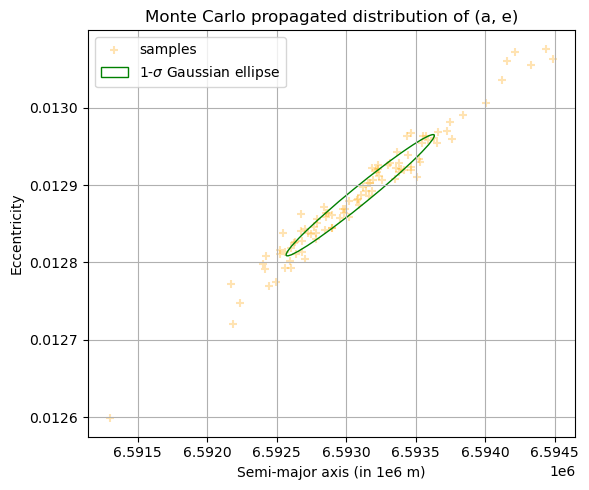

[[2.52500000e+05 3.70452976e-02]
 [3.70452976e-02 5.66283455e-09]]
[6.59313700e+06 1.28921882e-02]
[[2.52500000e+05 3.70452976e-02 0.00000000e+00 0.00000000e+00]
 [3.70452976e-02 5.66283455e-09 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.43214742e+04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e-02]]
[array([6.59313700e+06, 1.28921882e-02, 0.00000000e+00, 1.00000000e+00]), array([6.59426061e+06, 1.30570376e-02, 0.00000000e+00, 1.00000000e+00]), array([6.59201339e+06, 1.27273388e-02, 0.00000000e+00, 1.00000000e+00]), array([6.5931370e+06, 1.2925935e-02, 0.0000000e+00, 1.0000000e+00]), array([6.59313700e+06, 1.28584414e-02, 0.00000000e+00, 1.00000000e+00]), array([6.59313700e+06, 1.28921882e-02, 2.67595536e+02, 1.00000000e+00]), array([ 6.59313700e+06,  1.28921882e-02, -2.67595536e+02,  1.00000000e+00]), array([6.59313700e+06, 1.28921882e-02, 0.00000000e+00, 1.22360680e+00]), array([6.59313700e+06, 1.28921882e-02, 0.00000000e+00, 7.763932

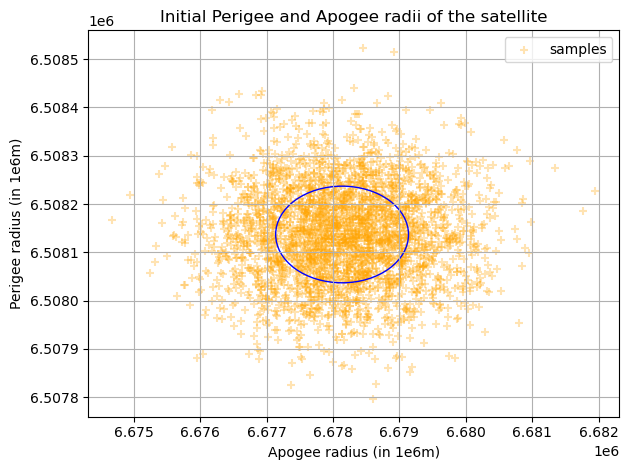

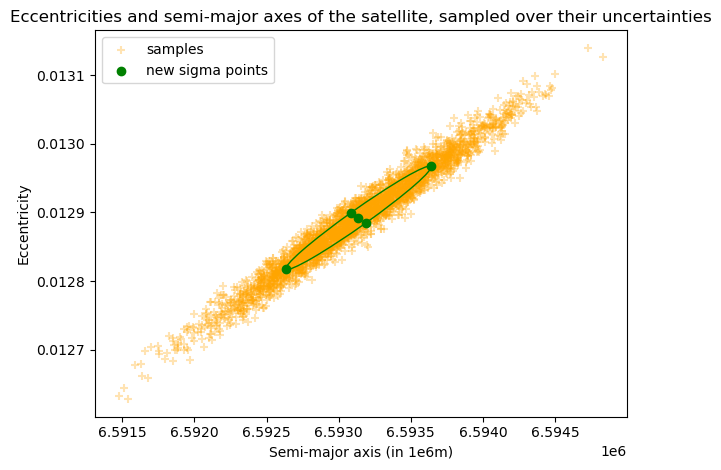

In [15]:
duration = 4*24*3600
sigma_rp = 100.0
sigma_ra = 1000.0
sigma_t = np.radians(0.5)/Constants.WGS84_EARTH_ANGULAR_VELOCITY
sigma_k = 0.1
mean = np.array([ra+Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                  rp+Constants.WGS84_EARTH_EQUATORIAL_RADIUS])
covariance = np.array([[sigma_ra**2, 0.0], [0.0, sigma_rp**2]])
initialgaussian = Gaussian(mean, covariance)

N = 100
rp_ra_samples = np.random.multivariate_normal(mean, covariance, size=N)

# Step 2: Transform each sample to (a, e)
a_samples = (rp_ra_samples[:, 0] + rp_ra_samples[:, 1]) / 2
e_samples = (rp_ra_samples[:, 0] - rp_ra_samples[:, 1]) / (rp_ra_samples[:, 1] + rp_ra_samples[:, 0])

ae_samples = np.vstack([a_samples, e_samples]).T

# Step 3: Estimate new mean and covariance
mu_ae = np.mean(ae_samples, axis=0)
covariance_ae = np.cov(ae_samples, rowvar=False)

print("Estimated mean of (a, e):")
print(mu_ae)
print("\nEstimated covariance of (a, e):")
print(covariance_ae)

# Step 4 (optional): Plot the sample cloud
plt.figure(figsize=(6, 5))
ax = plt.gca()
plt.scatter(a_samples, e_samples, alpha=0.3, label='samples', color = 'orange', marker = '+')
plot_ellipse(mu_ae, covariance_ae, ax, n_std=1, facecolor='none', edgecolor='green', label = '1-$\\sigma$ Gaussian ellipse')  
plt.xlabel("Semi-major axis (in 1e6 m)")
plt.ylabel("Eccentricity")
plt.title("Monte Carlo propagated distribution of (a, e)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

num_samples = 3000

sig_rpra = initialgaussian.compute_sigma_points()
rpra_ellipse_samples = [initialgaussian.sample() for _ in range(num_samples)]
x_rpra = [item[0] for item in rpra_ellipse_samples]
y_rpra = [item[1] for item in rpra_ellipse_samples]


sig_ae, gaussian_ae = sigma_points(mean, covariance)
print(gaussian_ae.covariance())
print(gaussian_ae.mean())
new_mean = np.zeros((4))
new_mean[:2] = gaussian_ae.mean()
new_mean[2] = 0.0
new_mean[3] = 1
new_covariance = np.zeros((4,4))
new_covariance[:2, :2] = gaussian_ae.covariance()
new_covariance[2, 2] = sigma_t**2
new_covariance[3, 3] = sigma_k**2
print(new_covariance)
new_covariance[3,0] = 0
new_covariance[0,3] = 0
newgaussian = Gaussian(new_mean, new_covariance)
sig_points = newgaussian.compute_sigma_points()
weights = newgaussian.compute_weights()
samples = [newgaussian.sample() for _ in range(num_samples)]
samples[:0] = sig_points
print(sig_points)
ae_ellipse_samples = [gaussian_ae.sample() for _ in range(num_samples)]
x_ae = [item[0] for item in ae_ellipse_samples]
y_ae = [item[1] for item in ae_ellipse_samples]

plt.figure()
ax = plt.gca()
plt.scatter(x_rpra, y_rpra, alpha = 0.3, color = 'orange', marker = '+', label = 'samples')
plot_ellipse(mean, covariance, ax, n_std=1, facecolor='none', edgecolor='blue')  
plt.title("Initial Perigee and Apogee radii of the satellite")
plt.xlabel("Apogee radius (in 1e6m)")
plt.ylabel("Perigee radius (in 1e6m)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure()
ax = plt.gca()
plt.scatter(x_ae, y_ae, alpha = 0.3, color = 'orange', marker = '+', label = 'samples')
plot_ellipse(gaussian_ae.mean(), gaussian_ae.covariance(), ax, n_std=1, facecolor='none', edgecolor='green')  
plt.scatter([x[0] for x in sig_ae], [x[1] for x in sig_ae], color='green', label = 'new sigma points')
plt.title("Eccentricities and semi-major axes of the satellite, sampled over their uncertainties")
plt.xlabel("Semi-major axis (in 1e6m)")
plt.ylabel("Eccentricity")
plt.legend()
plt.tight_layout()
plt.show()


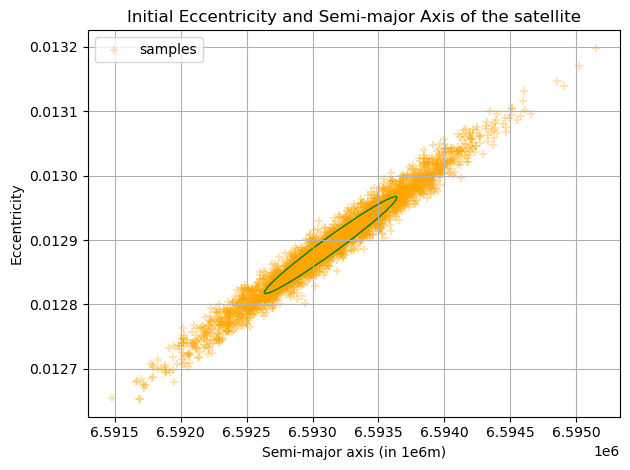

[6.59313700e+06 1.28921882e-02] [6.59313700e+06 1.28921938e-02]
[[2.52500000e+05 3.70452976e-02]
 [3.70452976e-02 5.66283455e-09]] [[2.52500000e+05 3.70452974e-02]
 [3.70452974e-02 5.66283449e-09]]


In [9]:
def non_linear_function(x):
    a = (x[0] + x[1]) / 2.0
    e = 1.0 - x[1] / a
    return np.array([a, e])

def jacobian_f(x):
    rp, ra = x
    a = (rp + ra) / 2.0

    da_drp = 0.5
    da_dra = 0.5
    de_drp = ra / (a ** 2) * da_drp
    de_dra = -1 / a + ra / (a ** 2) * da_dra

    J = np.array([[da_drp, da_dra],
                  [de_drp, de_dra]])
    return J

mean_ae = non_linear_function(mean)

J = jacobian_f(mean)

cov_ae = J @ covariance @ J.T

plt.figure()
ax = plt.gca()
plt.scatter(x_ae, y_ae, alpha = 0.3, color = 'orange', marker = '+', label = 'samples')
plot_ellipse(mean_ae, cov_ae, ax, n_std=1, facecolor='none', edgecolor='green')  
plt.title("Initial Eccentricity and Semi-major Axis of the satellite")
plt.xlabel("Semi-major axis (in 1e6m)")
plt.ylabel("Eccentricity")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

print(gaussian_ae.mean(), mean_ae)
print(gaussian_ae.covariance(), cov_ae)

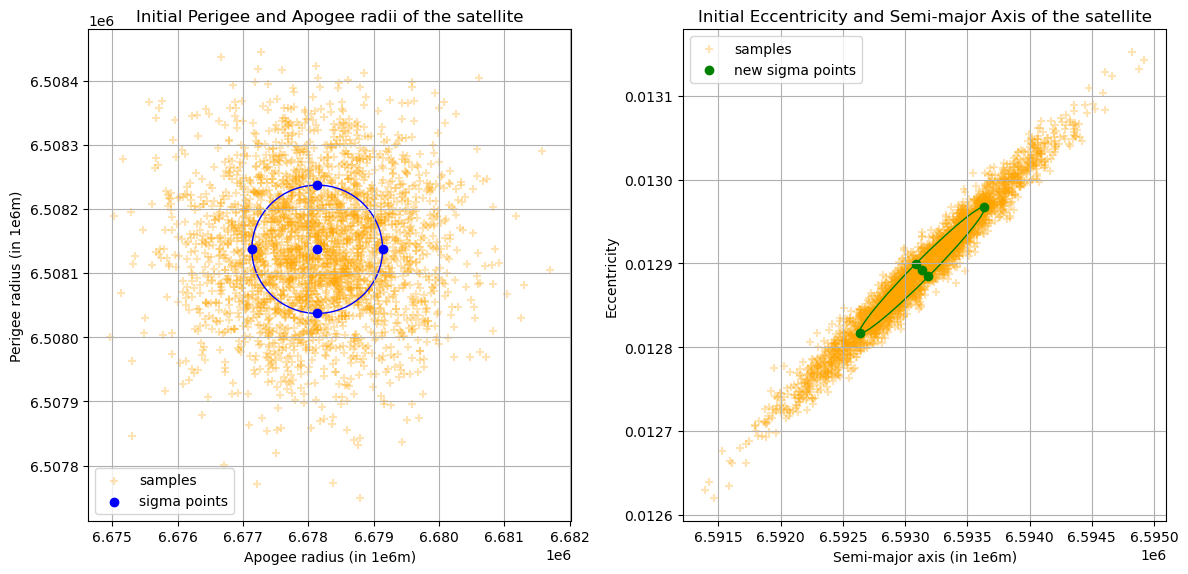

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# --- First subplot: Perigee vs Apogee ---
ax1.scatter(x_rpra, y_rpra, alpha=0.3, color='orange', marker='+', label='samples')
plot_ellipse(mean, covariance, ax1, n_std=1, facecolor='none', edgecolor='blue')  
ax1.scatter([x[0] for x in sig_rpra], [x[1] for x in sig_rpra], color='blue', label='sigma points')
ax1.set_title("Initial Perigee and Apogee radii of the satellite")
ax1.set_xlabel("Apogee radius (in 1e6m)")
ax1.set_ylabel("Perigee radius (in 1e6m)")
ax1.grid(True)
ax1.legend()

# --- Second subplot: Eccentricity vs Semi-major Axis ---
ax2.scatter(x_ae, y_ae, alpha=0.3, color='orange', marker='+', label='samples')
plot_ellipse(gaussian_ae.mean(), gaussian_ae.covariance(), ax2, n_std=1, facecolor='none', edgecolor='green')  
ax2.scatter([x[0] for x in sig_ae], [x[1] for x in sig_ae], color='green', label='new sigma points')
ax2.set_title("Initial Eccentricity and Semi-major Axis of the satellite")
ax2.set_xlabel("Semi-major axis (in 1e6m)")
ax2.set_ylabel("Eccentricity")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

Creates lists that will append the data obtained from the propagation. Propagation is done for each different sample, and the final data is recorded to be able to plot the variables and analyze them.

In [16]:
lat = []
lon = []
pa = []
time = []
positions = []
velocities = []
inc = []
ohm = []

for j in range(len(samples[:400])):
    pvs, final_state, final_state_orbit = numerical_propagation(samples[j])
    if j == 1:
        og_final_state = final_state_orbit
    v = pvs.getVelocity()
    p = pvs.getPosition()
    x = p.getX()
    y = p.getY()
    z = p.getZ()
    vx = v.getX()
    vy = v.getY()
    vz = v.getZ()
    position = [x, y, z]
    velocity = [vx, vy, vz]
    positions.append(position)
    velocities.append(velocity)
    t = initialDate.shiftedBy(float(final_state.getDate().durationFrom(initialDate)))
    RAAN = final_state_orbit.getRightAscensionOfAscendingNode()
    perig = final_state_orbit.getPerigeeArgument()
    incli = final_state_orbit.getI()
    trueano = final_state_orbit.getTrueAnomaly()
    pa.append(np.degrees(perig+trueano))
    time.append(final_state.getDate().durationFrom(initialDate)/3600)
    inc.append(np.degrees(incli))
    ohm.append(np.degrees(RAAN))
    print(final_state_orbit)
    subpoint = earth.transform(p, inertialFrame, t)
    lat.append(np.degrees(subpoint.getLatitude()))
    lon.append(np.degrees(subpoint.getLongitude()))

Keplerian parameters: {a: 5504551.088030245; e: 0.17360427690286961; i: 97.94526564660347; pa: 212.5776074091121; raan: 142.40644617478287; v: -172.82802477948425;}
Keplerian parameters: {a: 5619833.836406053; e: 0.14784072102347984; i: 98.12801320083165; pa: 243.91268315555283; raan: 142.4642456950085; v: -171.76348601363972;}
Keplerian parameters: {a: 5437539.850009897; e: 0.1891029265321953; i: 97.81280763316224; pa: 187.44234340021305; raan: 142.5043610725976; v: -173.7966878470853;}
Keplerian parameters: {a: 5469578.960813146; e: 0.18190021605607806; i: 97.85230238225935; pa: 196.0534952116429; raan: 142.4589435255043; v: -173.41829225429547;}
Keplerian parameters: {a: 5556368.086459285; e: 0.16156388051585677; i: 98.06602904143324; pa: 231.77486650036653; raan: 142.4184698070889; v: -172.18527739594512;}
Keplerian parameters: {a: 5504318.146015801; e: 0.17366578192860244; i: 97.94393430616557; pa: 212.36676288868884; raan: 142.40681285892734; v: -172.83394855517534;}
Keplerian pa

This defines 2 functions that will be used later, which is the Gaussian formula and a function that will unwrap the alpha angles obtained to see a linear dependance with time.

In [17]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def unwrap_angles(perigee):
    unwrapped = [perigee[0]]
    print(unwrapped[0])
    for i in range(1, len(perigee)):
        delta = perigee[i] - perigee[i-1]

        if delta < -180:
            unwrapped.append(unwrapped[-1] + (perigee[i] + 360 - perigee[i-1]))
        elif delta > 180:
            unwrapped.append(unwrapped[-1] + (perigee[i] - 360 - perigee[i-1]))
        else:
            unwrapped.append(unwrapped[-1] + delta)
    print(unwrapped[0])
    return unwrapped

def plot_ellipse(mean: np.ndarray, cov: np.ndarray, ax, n_std=1, num_points=900, **kwargs):

    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    theta = np.linspace(0, 2 * np.pi, num_points)
    ellipse_points = np.column_stack([
        ell_radius_x * np.cos(theta),
        ell_radius_y * np.sin(theta)
    ])

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])
    
    transformed_points = transf.transform(ellipse_points)

    ellipse_patch = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)
    ellipse_patch.set_transform(transf + ax.transData)
    ax.add_patch(ellipse_patch)

    return transformed_points

This plots the inclination and the right ascencion of the ascending node in terms of alpha. It shows a clear dependance, that we will be able to fit later on.

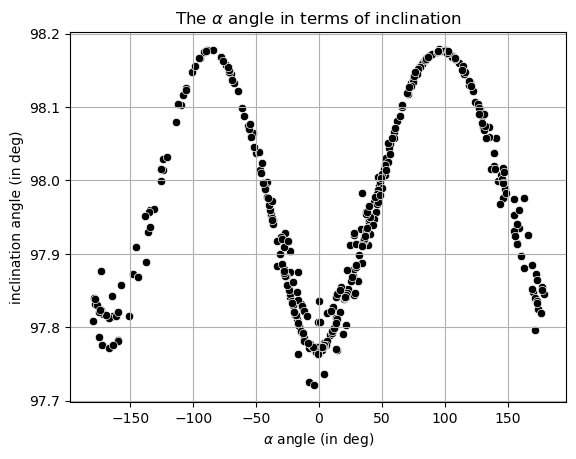

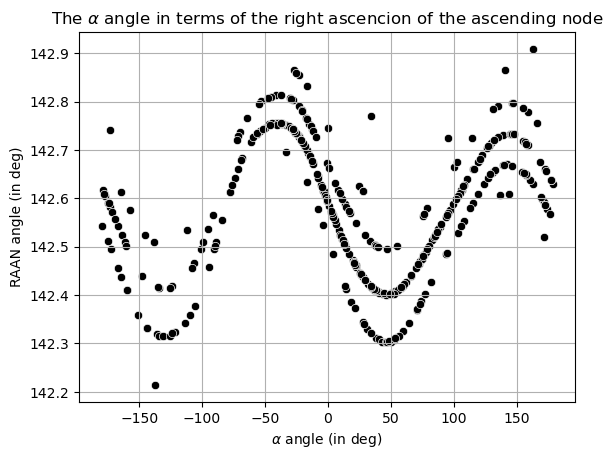

In [18]:
df = pd.DataFrame({
    '$\\alpha$ angle (in deg)': pa,
    'inclination angle (in deg)': inc
})

sns.scatterplot(data=df, x='$\\alpha$ angle (in deg)', y='inclination angle (in deg)', color='black')
plt.title('The $\\alpha$ angle in terms of inclination')
plt.grid(True)
plt.show()

df = pd.DataFrame({
    '$\\alpha$ angle (in deg)': pa,
    'RAAN angle (in deg)': ohm
})

sns.scatterplot(data=df, x='$\\alpha$ angle (in deg)', y='RAAN angle (in deg)', color='black')
plt.title('The $\\alpha$ angle in terms of the right ascencion of the ascending node')
plt.grid(True)
plt.show()

This part of the code will fit the inclination and RAAN data expressed in terms of the $\alpha$ angle. The fit is made using only the points calculated to determine the covariance of the resulting data using the unscented transform

Fitted inclination parameters (i0, i1, i2): [ 9.79970734e+01 -2.24722330e-02 -1.84166677e-01]
[10.43580893749112, 10.569880781552737, 10.326292811720297, 10.365156369314933, 10.517111274243831, 10.509261991674052, 10.361837092107413, 8.76997489839979, 13.308586526301013, 10.38098200038076, 10.185054140814302, 9.51141242308369, 10.378186508711476, 10.158502096968673, 10.397889240021733, 9.623329464314176, 10.875165627799829, 13.093982586592134, 10.167228538545071, 13.771868088932667, 10.143705941036519, 9.022256269326578, 10.351801254221241, 10.559961742289401, 10.91818379377254, 9.522527578303686, 10.536607578049123, 10.647490241766727, 12.095893918739083, 11.054260160917073, 8.966006964470893, 10.365252468179586, 9.4970061200898, 10.708329788396355, 10.391063344100774, 8.950740217090692, 11.72844279688527, 10.886769152815587, 9.543542911824657, 10.590565197774993, 9.300171868428732, 12.141416185864763, 10.939676643715218, 13.554636141383869, 10.559340852972094, 11.850511607641081, 9.7

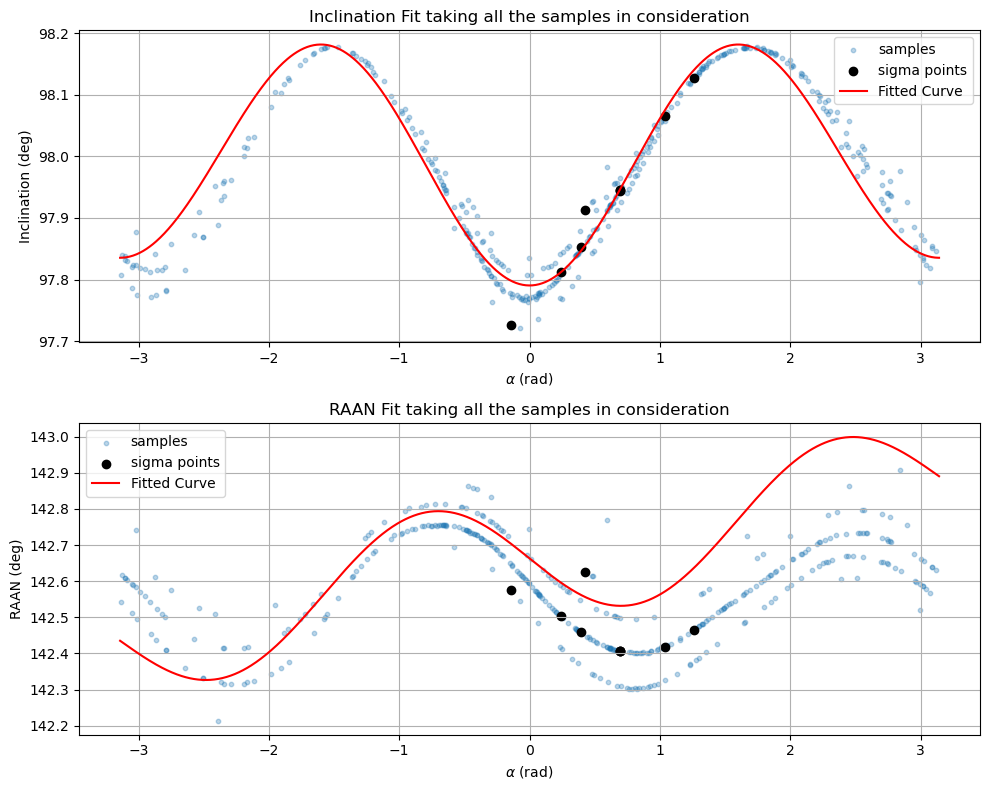

In [19]:
alpha_rad = np.radians(pa)

def inclination_fit(alpha, i0, i1, i2):
    return i0 + i1 * np.cos(alpha) + i2 * np.cos(2 * alpha)

def raan_fit(data, omega0, omega_dot, omega1, omega2):
    alpha, t = data
    return omega0 + omega_dot * t + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)


popt_i, _ = curve_fit(inclination_fit, alpha_rad, inc)
print("Fitted inclination parameters (i0, i1, i2):", popt_i)
print(time)
xdata = np.vstack((alpha_rad, time))
popt_omega, _ = curve_fit(raan_fit, xdata, ohm)
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega)


alpha_fit = np.linspace(-np.pi, np.pi, 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_fit(alpha_fit, *popt_i)
omega_fit = raan_fit((alpha_fit, t_fit), *popt_omega)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc, s = 10, alpha = 0.3, label = 'samples')
axs[0].scatter(alpha_rad[:9], inc[:9], label='sigma points', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit taking all the samples in consideration")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm, s = 10, alpha = 0.3, label = 'samples')
axs[1].scatter(alpha_rad[:9], ohm[:9], label='sigma points', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN Fit taking all the samples in consideration")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Fitted inclination parameters (i0, i1, i2): [97.7959045   0.2742877  -0.29572493]
Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂): [ 1.42007810e+02  5.79355890e-02 -5.32299376e-02 -1.76725442e-01]


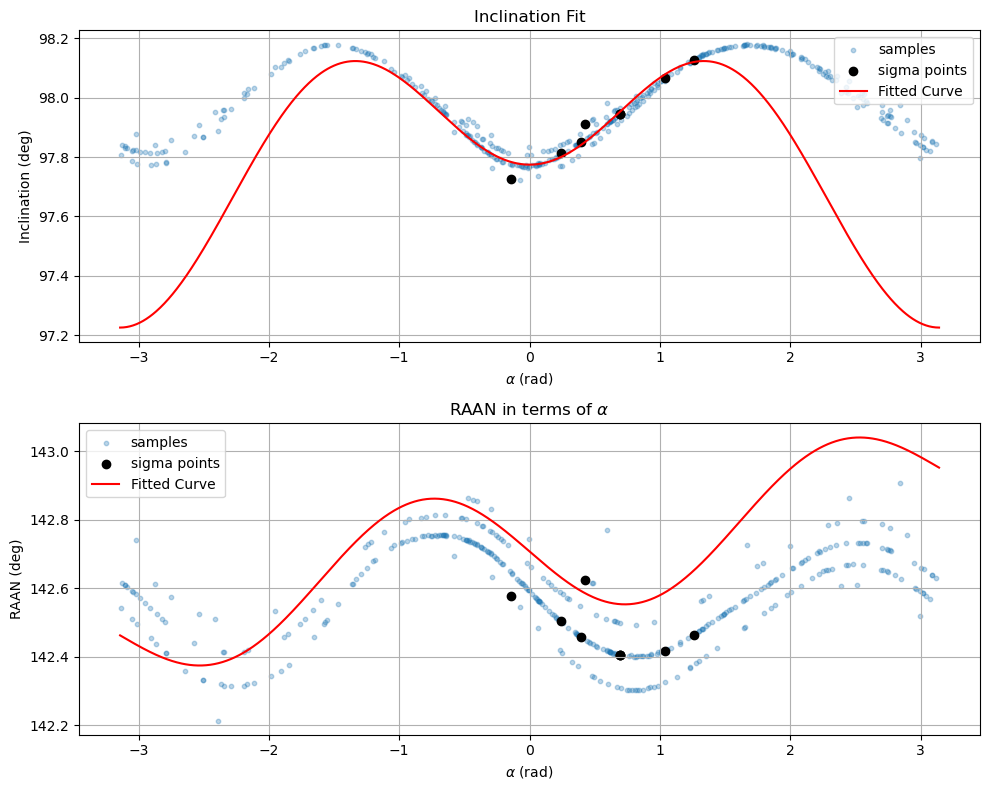

In [20]:
alpha_rad = np.radians(pa)
inc = np.array(inc)
def inclination_model(alpha, i0, i1, i2):
    return i0 + i1 * np.cos(alpha) + i2 * np.cos(2 * alpha)

def raan_model(data, omega0, omega_dot, omega1, omega2):
    alpha, t = data
    return omega0 + omega_dot * t + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)

max_index = np.argmax(alpha_rad)
min_index = np.argmin(alpha_rad)
zero_index = np.argmin(np.abs(alpha_rad))

new_indices = [0,1,2,3,4,5,6,7,8,max_index, min_index]
popt_i, _ = curve_fit(inclination_model, alpha_rad[:9], inc[:9])
print("Fitted inclination parameters (i0, i1, i2):", popt_i)

xdata = np.vstack((alpha_rad[:9], time[:9]))
popt_omega, _ = curve_fit(raan_model, xdata, ohm[:9])
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega)


alpha_fit = np.linspace(-np.pi, np.pi, 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_model(alpha_fit, *popt_i)
omega_fit = raan_model((alpha_fit, t_fit), *popt_omega)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc, s = 10, alpha = 0.3, label = 'samples')
axs[0].scatter(alpha_rad[:9], inc[:9], label='sigma points', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend(loc = 'upper right')
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm, s = 10, alpha = 0.3, label = 'samples')
axs[1].scatter(alpha_rad[:9], ohm[:9], label='sigma points', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN in terms of $\\alpha$")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


This converts the velocities into spherical coordinates to see if there is any strong deviation from the current position as the satellite lands on Earth.

This part of the code will utilize the unwrapping angles function to unwrap the alpha angles obtained, and will then plot the original alpha in terms of time and the unwrapped alpha in terms of time.

98.34269489014149
98.34269489014149


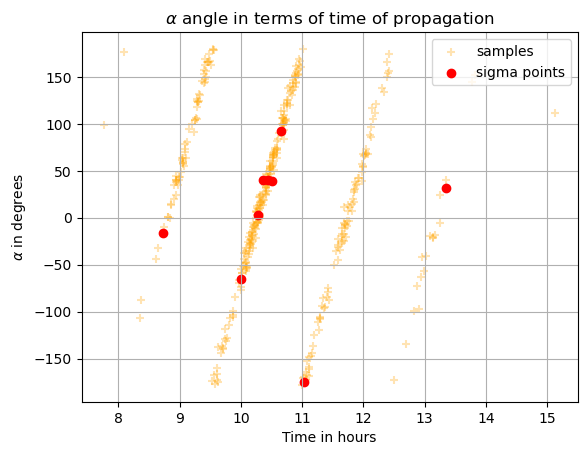

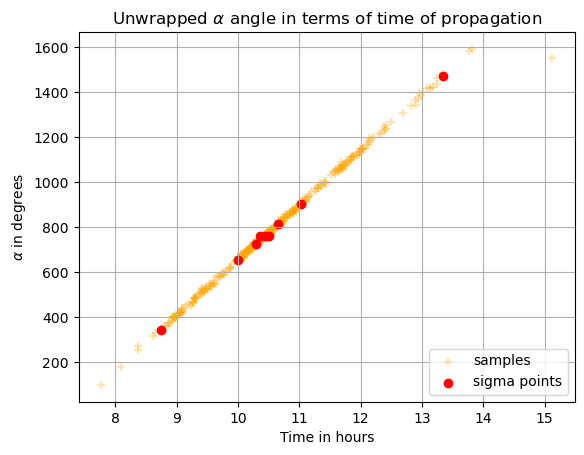

In [57]:
time = np.array(time)
pa = np.array(pa)
positions = np.array(positions)
ohm = np.array(ohm)
inc = np.array(inc)

sigma_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
sorted_indices = np.argsort(time)
time_sorted = time[sorted_indices]
pa_sorted = pa[sorted_indices]
ohm_sorted = ohm[sorted_indices]
inc_sorted = inc[sorted_indices]
reverse_lookup = {orig_idx: new_idx for new_idx, orig_idx in enumerate(sorted_indices)}
sigma_sorted_indices = [reverse_lookup[i] for i in sigma_indices]
unwrapped_pa = np.array(unwrap_angles(pa_sorted))


plt.figure()
plt.scatter(time[9:], pa[9:], color = "orange", alpha = 0.3, marker = "+", label= 'samples')
plt.scatter(time[:9], pa[:9], color = "red", label= 'sigma points')
plt.title("$\\alpha$ angle in terms of time of propagation")
plt.xlabel("Time in hours")
plt.ylabel("$\\alpha$ in degrees")
plt.grid(True)
plt.legend(loc= 'upper right')
plt.show()

plt.figure()
plt.scatter(time_sorted, unwrapped_pa, color = "orange", alpha = 0.3, marker = "+", label = 'samples')
plt.scatter(time_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices], color = "red", label = 'sigma points')
plt.xlabel("Time in hours")
plt.ylabel("$\\alpha$ in degrees")
plt.title("Unwrapped $\\alpha$ angle in terms of time of propagation")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


This part of the code, I'll try to change it so the $\alpha$ angle doesn't vary from -$\pi$ to $\pi$, but instead is also unwrapped, to see if there is a better fit that can be obtained like that.

Fitted inclination parameters (i0, i1, i2): [ 9.79941762e+01 -1.89538868e-02 -1.98605756e-01]
Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂): [ 1.42427888e+02  1.22150648e-02 -4.45112774e-02 -1.51052260e-01]


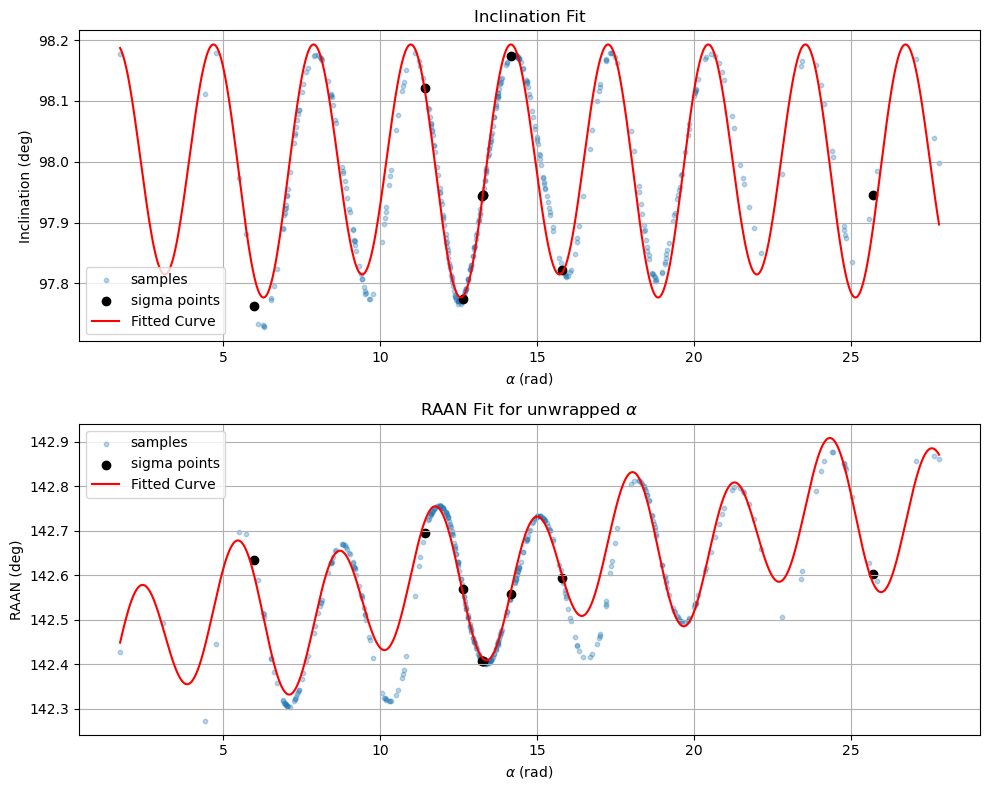

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [58]:
alpha_rad = np.radians(unwrapped_pa)

def raan_model_unwrapped(alpha, omega0, omega_alpha, omega1, omega2):
    return omega0 + omega_alpha*alpha + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)

indices = sigma_sorted_indices.copy()

popt_i_unwrapped, _ = curve_fit(inclination_model, alpha_rad[sigma_sorted_indices], inc[:9])
print("Fitted inclination parameters (i0, i1, i2):", popt_i_unwrapped)


popt_omega_unwrapped, _ = curve_fit(raan_model_unwrapped, alpha_rad[sigma_sorted_indices], ohm[:9])
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega_unwrapped)

alpha_fit = np.linspace(min(alpha_rad), max(alpha_rad), 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_model(alpha_fit, *popt_i_unwrapped)
omega_fit = raan_model_unwrapped(alpha_fit, *popt_omega_unwrapped)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc_sorted, s = 10, alpha = 0.3, label = 'samples')
axs[0].scatter(alpha_rad[sigma_sorted_indices], inc_sorted[sigma_sorted_indices], label='sigma points', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm_sorted, s = 10, alpha = 0.3, label = 'samples')
axs[1].scatter(alpha_rad[sigma_sorted_indices], ohm_sorted[sigma_sorted_indices], label='sigma points', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN Fit for unwrapped $\\alpha$")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

plt.figure()


This code will pick the transformed sigma points due to the propagation and create a Gaussian ellipse from it. It will then plot this ellipse onto the unwrapped alpha in terms of time plot, whilst creating a list of the points that the ellipse needs to be plotted.

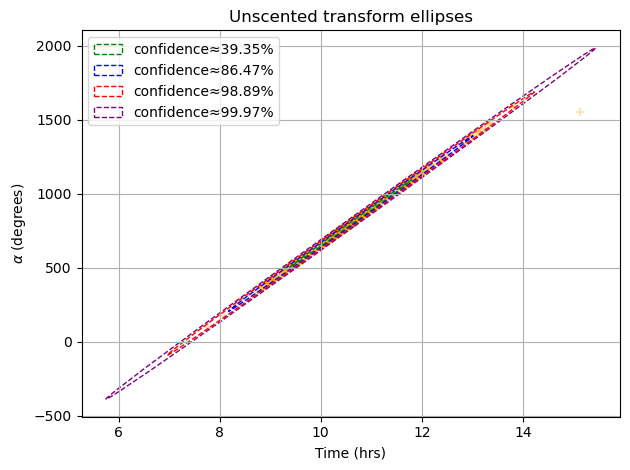

In [59]:
final_sig_points = [(t, x) for t, x in zip(time_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices])]
final_sig_points = np.array(final_sig_points)
final_sig_points = final_sig_points[np.argsort(final_sig_points[:, 0])]

final_mean = np.mean(final_sig_points, axis=0)
final_covariance = np.cov(final_sig_points, rowvar=False)

plt.figure()
ax = plt.gca()
plt.grid(True)
plt.scatter(time_sorted, unwrapped_pa, marker = "+", color = "orange", alpha = 0.3)
#plt.scatter(time_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices], color = 'red', marker = 'o')
ellipse1_points = plot_ellipse(final_mean, final_covariance, ax, n_std=1, facecolor='none', edgecolor='green', linestyle = '--', label = 'confidence≈39.35%') 
ellipse2_points = plot_ellipse(final_mean, final_covariance, ax, n_std=2, facecolor='none', edgecolor='blue', linestyle = '--', label = 'confidence≈86.47%')
ellipse3_points = plot_ellipse(final_mean, final_covariance, ax, n_std=3, facecolor='none', edgecolor='red', linestyle = '--', label = 'confidence≈98.89%')  
ellipse4_points = plot_ellipse(final_mean, final_covariance, ax, n_std=4, facecolor='none', edgecolor='purple', linestyle = '--', label = 'confidence≈99.97%')  
plt.title("Unscented transform ellipses")
plt.xlabel("Time (hrs)")
plt.ylabel("$\\alpha$ (degrees)")
plt.legend()
plt.tight_layout()
plt.show()


ellipse1_points[:, 1] = np.radians(ellipse1_points[:, 1])
ellipse2_points[:, 1] = np.radians(ellipse2_points[:, 1])
ellipse3_points[:, 1] = np.radians(ellipse3_points[:, 1])
ellipse4_points[:, 1] = np.radians(ellipse4_points[:, 1])
raan_ell1 = [raan for raan in raan_model_unwrapped(ellipse1_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]
raan_ell2 = [raan for raan in raan_model_unwrapped(ellipse2_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]
raan_ell3 = [raan for raan in raan_model_unwrapped(ellipse3_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]
raan_ell4 = [raan for raan in raan_model_unwrapped(ellipse4_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]

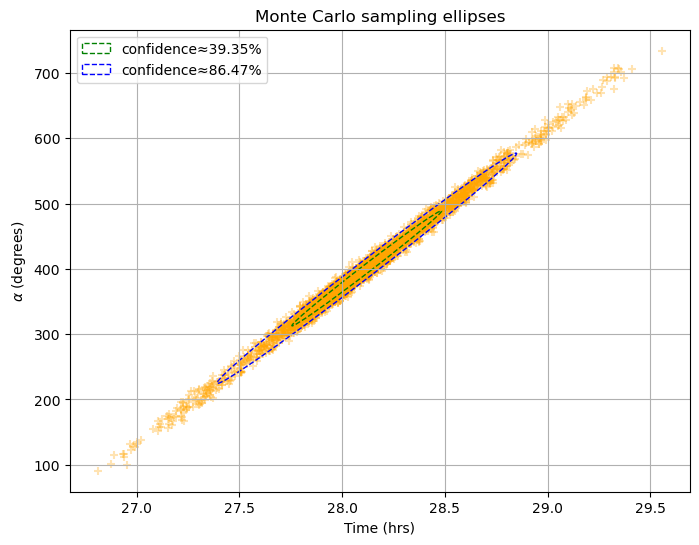

In [19]:
all_points = [(t, x) for t, x in zip(time_sorted, unwrapped_pa)]
all_points = np.array(all_points)

points_mean = np.mean(all_points, axis = 0)
points_cov = np.cov(all_points.T)

eigvals, eigvecs = np.linalg.eigh(points_cov)
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
width, height = 2 * np.sqrt(eigvals)

n_std = 1

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(all_points[:, 0], all_points[:, 1], alpha=0.3, color = 'orange', marker = '+')
plot_ellipse(points_mean, points_cov, ax, n_std=1, facecolor='none', edgecolor='green', linestyle = '--', label = 'confidence≈39.35%') 
plot_ellipse(points_mean, points_cov, ax, n_std=2, facecolor='none', edgecolor='blue', linestyle = '--', label = 'confidence≈86.47%')   
ax.set_title('Monte Carlo sampling ellipses')
plt.xlabel("Time (hrs)")
plt.ylabel("$\\alpha$ (degrees)")
plt.grid(True)
plt.legend()
plt.show()

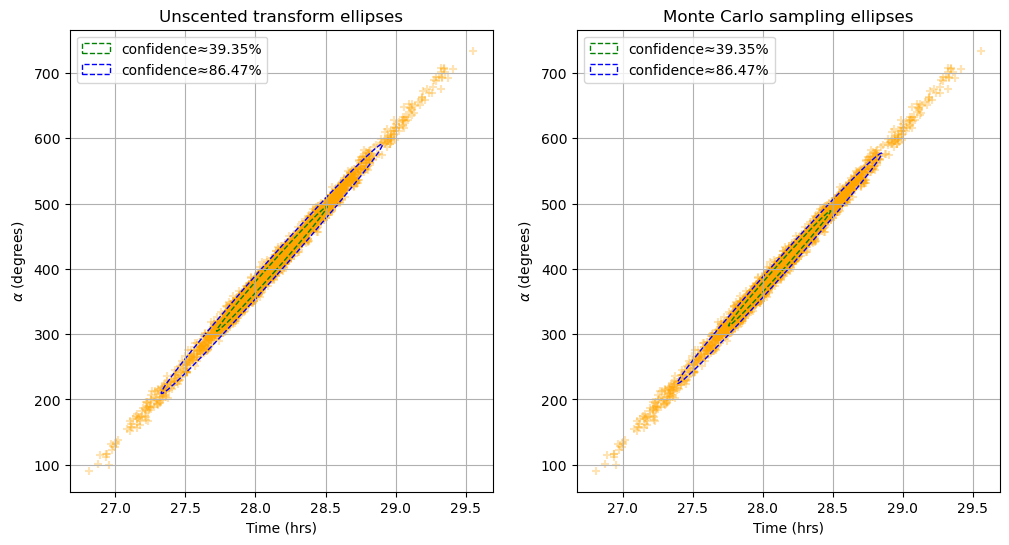

In [20]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

ax1.scatter(time_sorted, unwrapped_pa, marker = "+", color = "orange", alpha = 0.3)
plot_ellipse(final_mean, final_covariance, ax1, n_std=1, facecolor='none', edgecolor='green', linestyle = '--', label = 'confidence≈39.35%') 
plot_ellipse(final_mean, final_covariance, ax1, n_std=2, facecolor='none', edgecolor='blue', linestyle = '--', label = 'confidence≈86.47%')
ax1.set_title("Unscented transform ellipses")
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("$\\alpha$ (degrees)")
ax1.grid(True)
ax1.legend()

ax2.scatter(all_points[:, 0], all_points[:, 1], alpha=0.3, color = 'orange', marker = '+')
plot_ellipse(points_mean, points_cov, ax2, n_std=1, facecolor='none', edgecolor='green', linestyle = '--', label = 'confidence≈39.35%') 
plot_ellipse(points_mean, points_cov, ax2, n_std=2, facecolor='none', edgecolor='blue', linestyle = '--', label = 'confidence≈86.47%')   
ax2.set_title('Monte Carlo sampling ellipses')
plt.xlabel("Time (hrs)")
plt.ylabel("$\\alpha$ (degrees)")
plt.grid(True)
plt.legend()
plt.show()

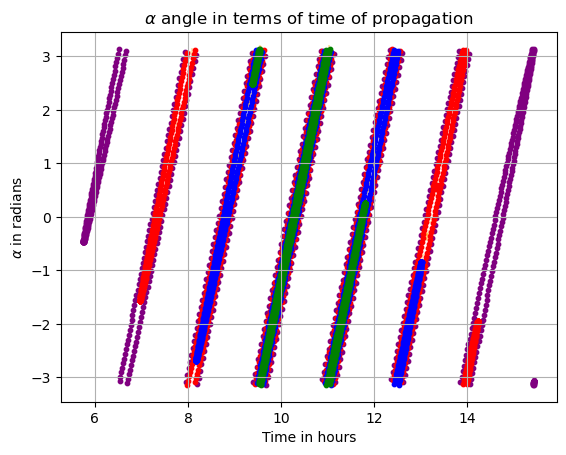

In [ ]:
ellipse1_wrapped = ellipse1_points.copy()
ellipse2_wrapped = ellipse2_points.copy()
ellipse4_wrapped = ellipse4_points.copy()
ellipse3_wrapped = ellipse3_points.copy()

for k in range(len(ellipse4_wrapped)):
    if ellipse1_wrapped[k][1]>np.pi:
        ellipse1_wrapped[k][1] = ellipse1_wrapped[k][1]-2*np.pi
    if ellipse2_wrapped[k][1]>np.pi:
        ellipse2_wrapped[k][1] = ellipse2_wrapped[k][1]-2*np.pi
    if ellipse2_wrapped[k][1]<-np.pi:
        ellipse2_wrapped[k][1] = ellipse2_wrapped[k][1]+2*np.pi
    if ellipse4_wrapped[k][1]>np.pi:
        ellipse4_wrapped[k][1] = ellipse4_wrapped[k][1]-2*np.pi
    if ellipse4_wrapped[k][1]<-np.pi:
        ellipse4_wrapped[k][1] = ellipse4_wrapped[k][1]+2*np.pi
    if ellipse3_wrapped[k][1]>np.pi:
        ellipse3_wrapped[k][1] = ellipse3_wrapped[k][1]-2*np.pi
    if ellipse3_wrapped[k][1]<-np.pi:
        ellipse3_wrapped[k][1] = ellipse3_wrapped[k][1]+2*np.pi

        
pa_rad = np.radians(pa)

plt.figure()
plt.scatter(time[7:], pa_rad[7:], color = "orange", alpha = 0.3, marker = "+")
plt.scatter(time[:7], pa_rad[:7], color = "red")
plt.scatter(ellipse4_wrapped[:,0], ellipse4_wrapped[:,1], s=10, color= 'purple')
plt.scatter(ellipse3_wrapped[:,0], ellipse3_wrapped[:,1], s=10, color= 'red')
plt.scatter(ellipse2_wrapped[:,0], ellipse2_wrapped[:,1], s=10, color= 'blue')
plt.scatter(ellipse1_wrapped[:,0], ellipse1_wrapped[:,1], s=10, color= 'green')



plt.title("$\\alpha$ angle in terms of time of propagation")
plt.xlabel("Time in hours")
plt.ylabel("$\\alpha$ in radians")
plt.grid(True)
plt.show()

This converts the ellipse points into latitudes and longitudes, by considering that only the time and perigee angles vary, which means that we take the mean satellite point and simply vary its initial parameters with the new perigee and time. This is obviously not correct, and is not a good way to approximate it, which is why we will be fitting the inclination and the right ascencion of the ascending node to determine better orbital parameters for the ellipse to determine its longitude and latitude.

In [ ]:
time_ell1 = [time for time in ellipse1_wrapped[:,0]]
time_ell2 = [time for time in ellipse2_wrapped[:,0]]
time_ell3 = [time for time in ellipse3_wrapped[:,0]]
time_ell4 = [time for time in ellipse4_wrapped[:,0]]

alpha_ell1 = [alpha for alpha in ellipse1_wrapped[:,1]]
alpha_ell2 = [alpha for alpha in ellipse2_wrapped[:,1]]
alpha_ell3 = [alpha for alpha in ellipse3_wrapped[:,1]]
alpha_ell4 = [alpha for alpha in ellipse4_wrapped[:,1]]

inc_ell1 = [inc for inc in inclination_model(ellipse1_wrapped[:,1], popt_i[0], popt_i[1], popt_i[2])]
inc_ell2 = [inc for inc in inclination_model(ellipse2_wrapped[:,1], popt_i[0], popt_i[1], popt_i[2])]
inc_ell3 = [inc for inc in inclination_model(ellipse3_wrapped[:,1], popt_i[0], popt_i[1], popt_i[2])]
inc_ell4 = [inc for inc in inclination_model(ellipse4_wrapped[:,1], popt_i[0], popt_i[1], popt_i[2])]

In [62]:
ell1_x = []
ell1_y = []
ell1_z = []
ell1_lat = []
ell1_lon = []
ell2_x = []
ell2_y = []
ell2_z = []
ell2_lat = []
ell2_lon = []
ell4_x = []
ell4_y = []
ell4_z = []
ell4_lat = []
ell4_lon = []
ell3_x = []
ell3_y = []
ell3_z = []
ell3_lat = []
ell3_lon = []


for k in range(len(ellipse1_wrapped)):
    ell1_orbit = KeplerianOrbit(float(Constants.WGS84_EARTH_EQUATORIAL_RADIUS+80000.0), float(0.0), float(np.radians(inc_ell1[k])),
         float(alpha_ell1[k]), float(np.radians(raan_ell1[k])), float(0.0),
         PositionAngleType.TRUE, final_state.getFrame(), initialDate.shiftedBy(float(time_ell1[k]*3600.0)), Constants.WGS84_EARTH_MU)
    ell1_x.append(ell1_orbit.getPosition().getX())
    ell1_y.append(ell1_orbit.getPosition().getY())
    ell1_z.append(ell1_orbit.getPosition().getZ())
    p = ell1_orbit.getPosition()
    subpoint = earth.transform(p, inertialFrame, initialDate.shiftedBy(float(time_ell1[k]*3600.0)))
    ell1_lat.append(np.degrees(subpoint.getLatitude()))
    ell1_lon.append(np.degrees(subpoint.getLongitude()))
    ell2_orbit = KeplerianOrbit(float(Constants.WGS84_EARTH_EQUATORIAL_RADIUS+80000.0), float(0.0), float(np.radians(inc_ell2[k])),
         float(alpha_ell2[k]), float(np.radians(raan_ell2[k])), float(0.0),
         PositionAngleType.TRUE, final_state.getFrame(), initialDate.shiftedBy(float(time_ell2[k]*3600.0)), Constants.WGS84_EARTH_MU)
    ell2_x.append(ell2_orbit.getPosition().getX())
    ell2_y.append(ell2_orbit.getPosition().getY())
    ell2_z.append(ell2_orbit.getPosition().getZ())
    p = ell2_orbit.getPosition()
    subpoint = earth.transform(p, inertialFrame, initialDate.shiftedBy(float(time_ell2[k]*3600.0)))
    ell2_lat.append(np.degrees(subpoint.getLatitude()))
    ell2_lon.append(np.degrees(subpoint.getLongitude()))
    ell3_orbit = KeplerianOrbit(float(Constants.WGS84_EARTH_EQUATORIAL_RADIUS+80000.0), float(0.0), float(np.radians(inc_ell3[k])),
         float(alpha_ell3[k]), float(np.radians(raan_ell3[k])), float(0.0),
         PositionAngleType.TRUE, final_state.getFrame(), initialDate.shiftedBy(float(time_ell3[k]*3600.0)), Constants.WGS84_EARTH_MU)
    ell3_x.append(ell3_orbit.getPosition().getX())
    ell3_y.append(ell3_orbit.getPosition().getY())
    ell3_z.append(ell3_orbit.getPosition().getZ())
    p = ell3_orbit.getPosition()
    subpoint = earth.transform(p, inertialFrame, initialDate.shiftedBy(float(time_ell3[k]*3600.0)))
    ell3_lat.append(np.degrees(subpoint.getLatitude()))
    ell3_lon.append(np.degrees(subpoint.getLongitude()))
    ell4_orbit = KeplerianOrbit(float(Constants.WGS84_EARTH_EQUATORIAL_RADIUS+80000.0), float(0.0), float(np.radians(inc_ell4[k])),
         float(alpha_ell4[k]), float(np.radians(raan_ell4[k])), float(0.0),
         PositionAngleType.TRUE, final_state.getFrame(), initialDate.shiftedBy(float(time_ell4[k]*3600.0)), Constants.WGS84_EARTH_MU)
    ell4_x.append(ell4_orbit.getPosition().getX())
    ell4_y.append(ell4_orbit.getPosition().getY())
    ell4_z.append(ell4_orbit.getPosition().getZ())
    p = ell4_orbit.getPosition()
    subpoint = earth.transform(p, inertialFrame, initialDate.shiftedBy(float(time_ell4[k]*3600.0)))
    ell4_lat.append(np.degrees(subpoint.getLatitude()))
    ell4_lon.append(np.degrees(subpoint.getLongitude()))


In [ ]:

alt = np.array([80]*len(ell1_lon))
elx = (alt+6378) * np.cos(np.radians(ell2_lat)) * np.cos(np.radians(ell2_lon))
ely = (alt+6378) * np.cos(np.radians(ell2_lat)) * np.sin(np.radians(ell2_lon))
elz = (alt+6378) * np.sin(np.radians(ell2_lat))


import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=elx,y=ely,z=elz,
                                   mode='markers',marker=dict(size=5, color='blue', opacity=0.7))])


latitudes = np.arange(-90, 91, 10)
for lati in latitudes:
    lat_x = np.cos(np.radians(lati)) * np.cos(np.radians(np.linspace(0, 360, 100))) * 6371
    lat_y = np.cos(np.radians(lati)) * np.sin(np.radians(np.linspace(0, 360, 100))) * 6371
    lat_z = np.full_like(lat_x, 6371 * np.sin(np.radians(lati)))
    
    fig.add_trace(go.Scatter3d(x=lat_x, y=lat_y, z=lat_z,mode='lines',line=dict(color='green', width=2)))

longitudes = np.arange(-180, 181, 30)
for long in longitudes:
    lon_x = np.cos(np.radians(np.linspace(-90, 90, 100))) * np.cos(np.radians(long)) * 6371
    lon_y = np.cos(np.radians(np.linspace(-90, 90, 100))) * np.sin(np.radians(long)) * 6371
    lon_z = np.sin(np.radians(np.linspace(-90, 90, 100))) * 6371
    
    fig.add_trace(go.Scatter3d(x=lon_x, y=lon_y, z=lon_z,mode='lines',line=dict(color='red', width=2)))

fig.update_layout(scene=dict(xaxis_title="X",yaxis_title="Y",zaxis_title="Z"))
fig.write_html("satellite_plot.html")
fig.show()


This creates the ground track for visualisation of the satellite points and the ellipse points. There is a clear issue stemming from the ellipse points as they do not encase the points well enough. This must be due to the code directly inputting the $\alpha$ angle in as the perigee angle, when it is a combination of the perigee and the true anomaly. Will get back to this soon.

Text(0.5, 1.0, 'World Map')

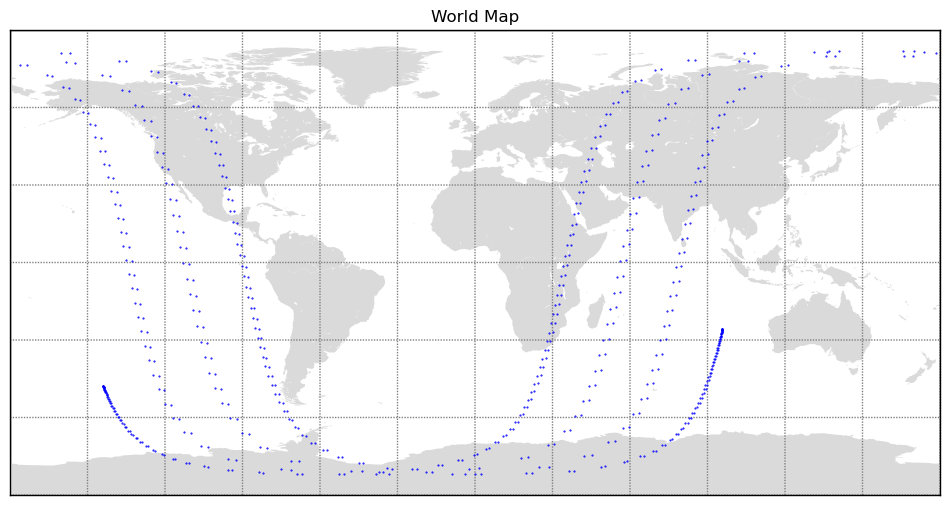

In [33]:
fig = plt.figure(figsize=(12, 10))
m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')
#m.scatter(lon, lat, s = 1, color = 'red', zorder= 3, marker = '.')
#m.scatter(ell1_lon, ell1_lat, s = 1, alpha = 1, color = 'green', zorder=3, marker= '.')
m.scatter(ell2_lon, ell2_lat, s = 1, alpha = 1, color = 'blue', zorder=3, marker='.')
#m.scatter(ell3_lon, ell3_lat, s = 1, alpha = 1, color = 'red', zorder=3, marker='.')
#m.scatter(ell4_lon, ell4_lat, s = 10, alpha = 1, color = 'purple', zorder=3, marker='.')
plt.title("World Map")


7


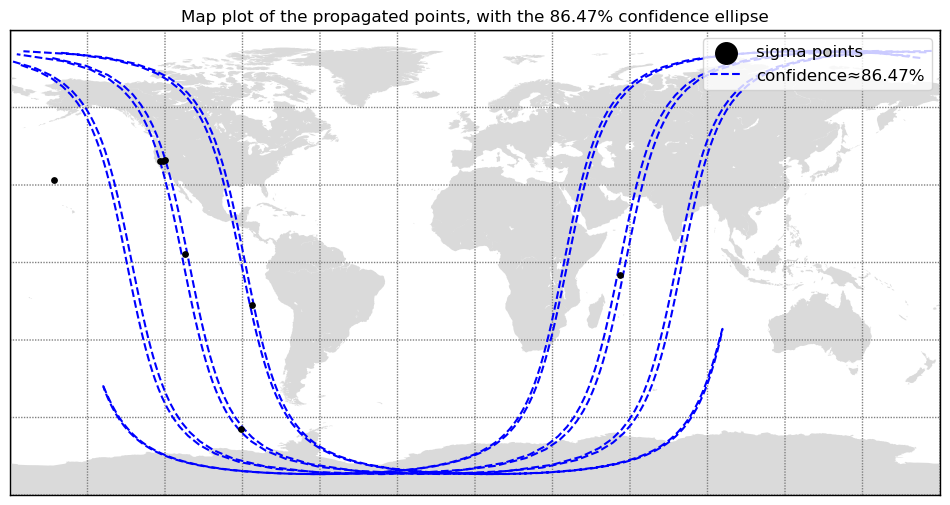

In [63]:
def break_ground_track(lons, lats, threshold=180):
    segments = []
    segment_lon = [lons[0]]
    segment_lat = [lats[0]]

    for i in range(1, len(lons)):
        if abs(lons[i] - lons[i-1]) > threshold / 2:
            # Discontinuity found
            segments.append((segment_lon, segment_lat))
            segment_lon = [lons[i]]
            segment_lat = [lats[i]]
        else:
            segment_lon.append(lons[i])
            segment_lat.append(lats[i])
    segments.append((segment_lon, segment_lat))
    return segments

# Break the blue track into segments
blue_segments = break_ground_track(ell2_lon, ell2_lat)
green_segments = break_ground_track(ell1_lon, ell1_lat)
red_segments = break_ground_track(ell3_lon, ell3_lat)
purple_segments = break_ground_track(ell4_lon, ell4_lat)



g = plt.figure(figsize=(12, 10))
m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')
m.scatter(lon[:9], lat[:9], s = 15, color = 'black', zorder= 3, marker = 'o', label = 'sigma points')
i = 1
for lon_seg, lat_seg in blue_segments:
    if i==1:
        m.plot(lon_seg, lat_seg, latlon=True, color='blue', linestyle = "--", label = "confidence≈86.47%")
        i+=1
    else:
        m.plot(lon_seg, lat_seg, latlon=True, color='blue', linestyle = "--")
plt.title("Map plot of the propagated points, with the 86.47%" +" confidence ellipse")
plt.legend(markerscale=4, loc='upper right', fontsize=12)

print(len(blue_segments))

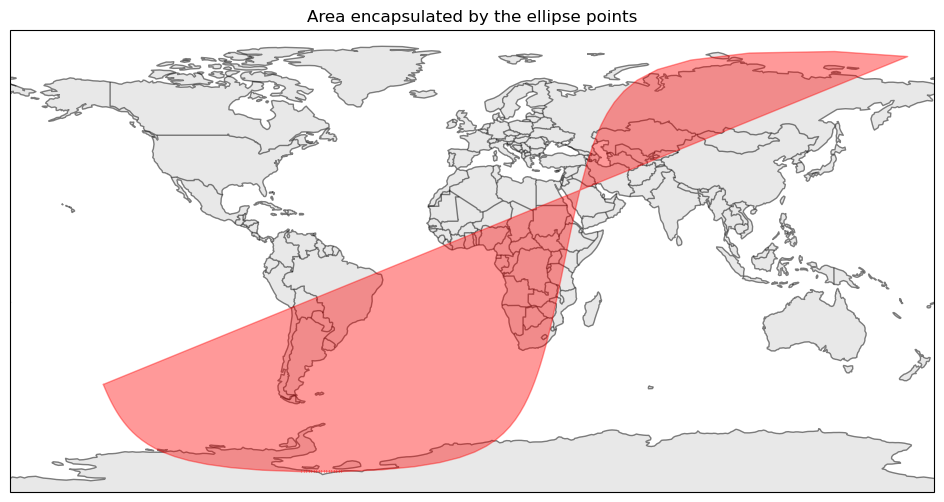

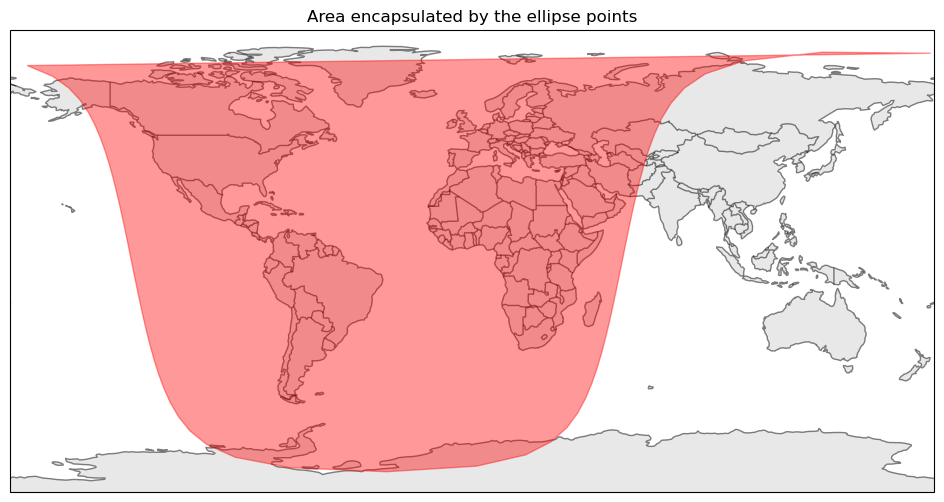

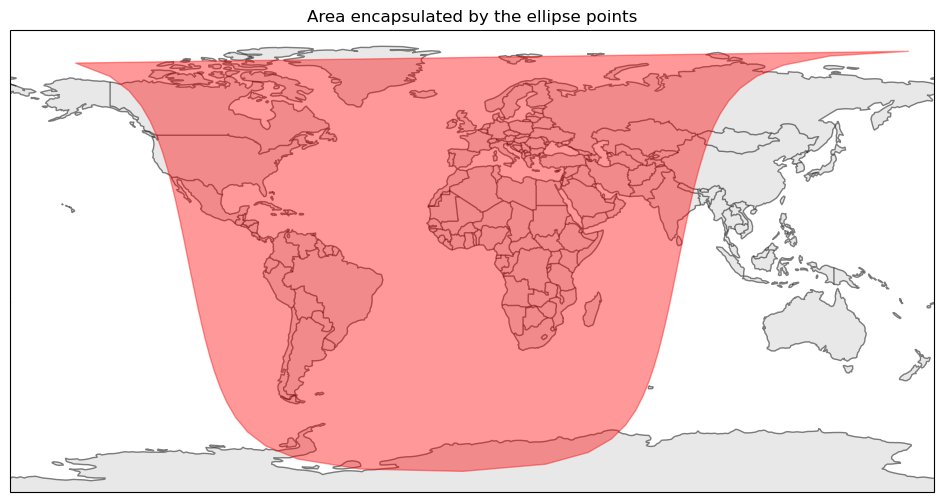

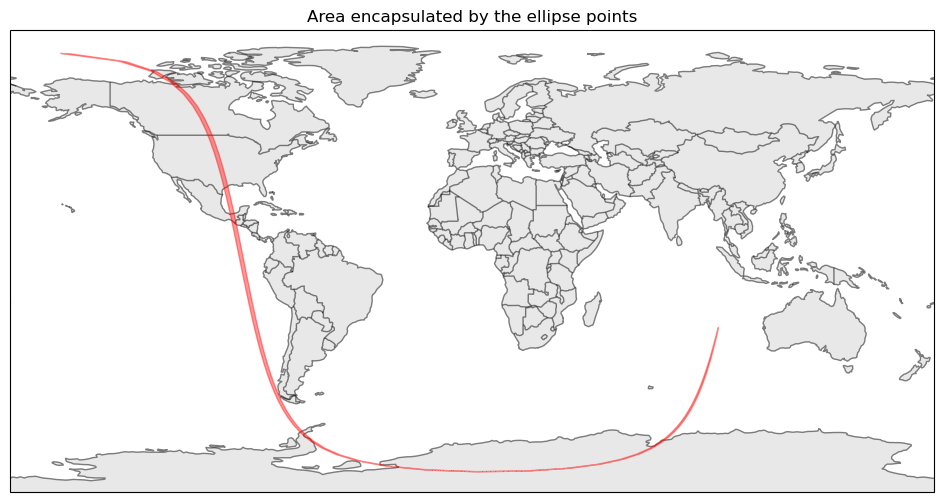

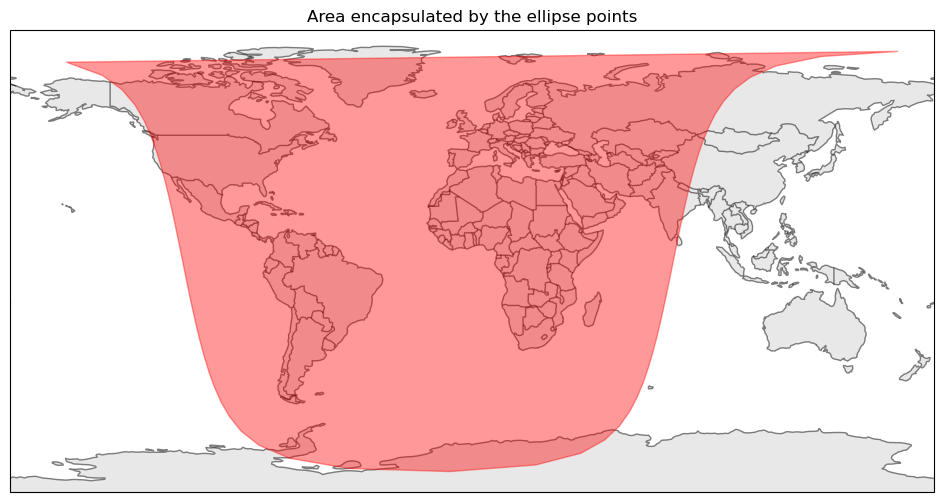

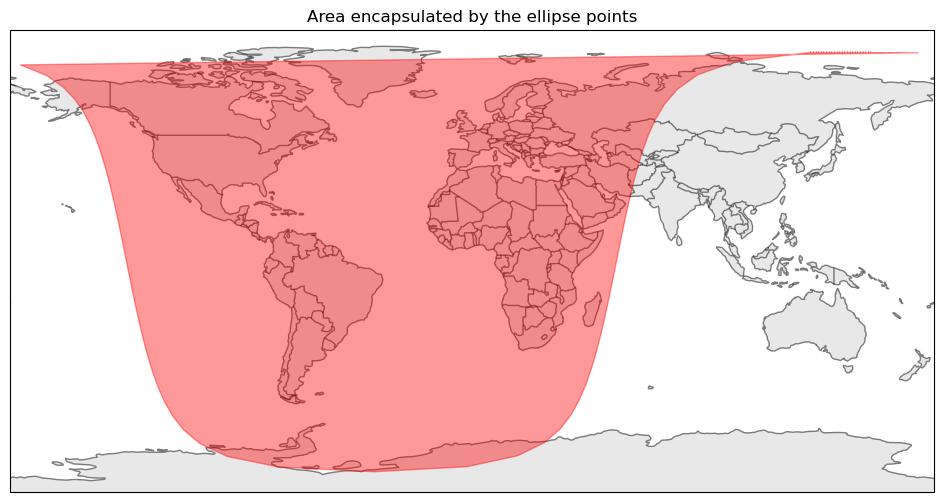

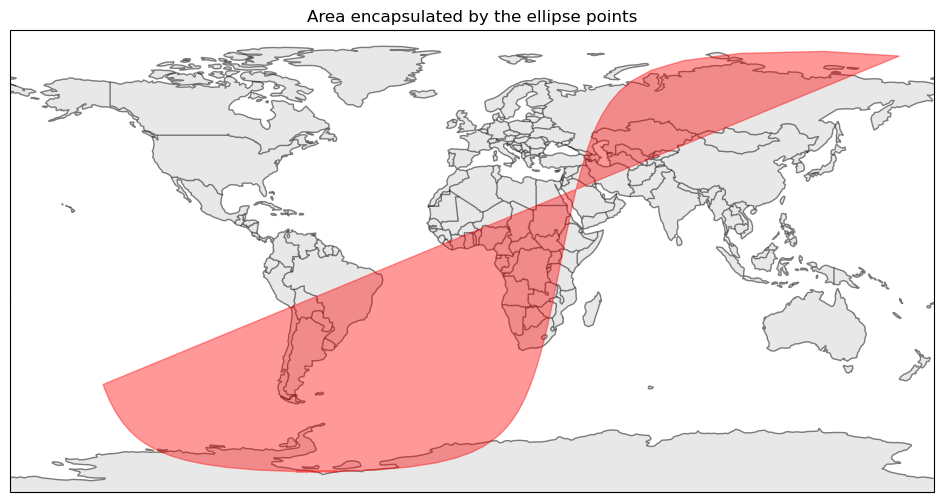

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj
import matplotlib.patches as mpatches

for lon_seg, lat_seg in blue_segments:
    lons = np.array(lon_seg)  
    lats = np.array(lat_seg)

    points = list(zip(lons, lats))
    poly = Polygon(points)

    proj = ccrs.PlateCarree(central_longitude=0)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=proj)
    ax.set_global()
    ax.coastlines(alpha = 0.5)
    ax.add_feature(cfeature.BORDERS, alpha = 0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha = 0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    project_back = pyproj.Transformer.from_proj(
        pyproj.Proj(proj='latlong', datum='WGS84'),
        pyproj.Proj(proj='latlong', datum='WGS84')
    ).transform

    ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor='red', alpha=0.4, edgecolor = 'red')

    plt.title("Area encapsulated by the ellipse points")
    plt.show()

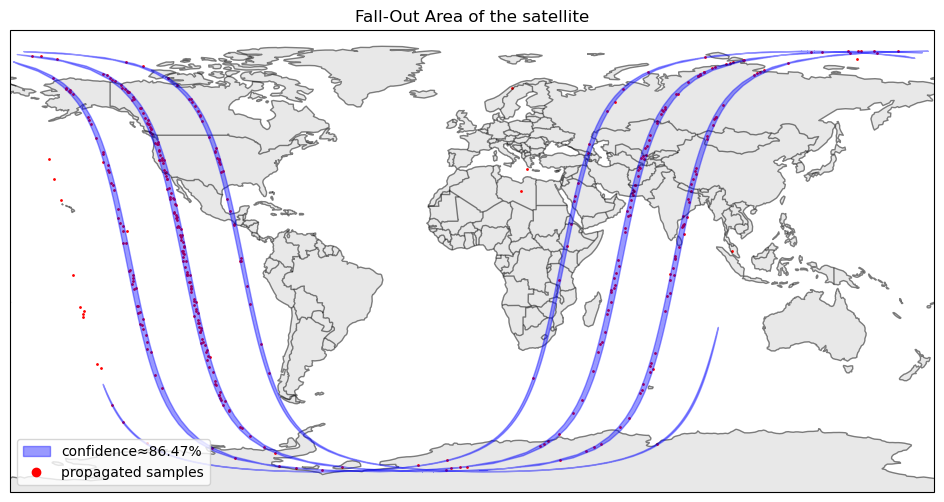

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


#if len == 11:
#i = 1
#for lon_seg, lat_seg in blue_segments:
#    lon_seg = np.array(lon_seg)
#    lat_seg = np.array(lat_seg)
#    points = list(zip(lon_seg, lat_seg))
#    if i == 1:
#        points1 = points
#    if i == 2:
#        points2 = points
#    if i == 3:
#        points3 = points
#    if i == 4:
#        points4 = points
#    if i == 5:
#        points5 = points
#    if i == 6:
#        bpoly1 = Polygon(points)
#    if i == 7:
#        all_points = points5 + points
#        bpoly2 = Polygon(all_points)
#    if i == 8:
#        all_points = points4 + points
#        bpoly3 = Polygon(all_points)
#    if i == 9:
#        all_points = points3 + points
#        bpoly4 = Polygon(all_points)
#    if i == 10:
#        all_points = points2 + points
#        bpoly5 = Polygon(all_points)
#    if i == 11:
#        all_points = points1 + points
#        bpoly6 = Polygon(all_points)
#    i += 1

#if len == 9:
#i = 1
#for lon_seg, lat_seg in blue_segments:
#    lon_seg = np.array(lon_seg)
#    lat_seg = np.array(lat_seg)
#    points = list(zip(lon_seg, lat_seg))
#    if i == 1:
#        points1 = points
#    if i == 2:
#        points2 = points
#    if i == 3:
#        points3 = points
#    if i == 4:
#        points4 = points
#    if i == 5:
#        bpoly1 = Polygon(points)
#    if i == 6:
#        all_points = points4 + points
#        bpoly2 = Polygon(all_points)
#    if i == 7:
#        all_points = points3 + points
#        bpoly3 = Polygon(all_points)
#    if i == 8:
#        all_points = points2 + points
#        bpoly4 = Polygon(all_points)
#    if i == 9:
#        all_points = points1 + points
#        bpoly5 = Polygon(all_points)
#    i += 1

#if len == 7:
i = 1
for lon_seg, lat_seg in blue_segments:
    lons = np.array(lon_seg)  
    lats = np.array(lat_seg)
    points = list(zip(lons, lats))
    if i == 1:
        points1 = points
    if i == 2:
        points2 = points
    if i == 3:
        points3 = points
    if i == 4:
        bpoly1 = Polygon(points)
    if i == 5:
        all_points = points3 + points
        bpoly2 = Polygon(all_points)
    if i == 6:
        all_points = points2 + points
        bpoly3 = Polygon(all_points)
    if i == 7:
        all_points = points1 + points
        bpoly4 = Polygon(all_points)
    i += 1


#For len == 5:

#i = 1
#for lon_seg, lat_seg in red_segments:
#    lon_seg = np.array(lon_seg)  
#    lat_seg = np.array(lat_seg)
#    points = list(zip(lon_seg, lat_seg))
#    if i == 1:
#        points1 = points
#    if i == 2:
#        points2 = points
#    if i == 3:
#        bpoly1 = Polygon(points)
#    if i == 4:
#        all_points = points2 + points
#        bpoly2 = Polygon(all_points)
#    if i == 5:
#        all_points = points1 + points
#        bpoly3 = Polygon(all_points)
#    i += 1

#For len == 3:

#i = 1
#for lon_seg, lat_seg in blue_segments:
#    lons = np.array(lon_seg)  
#    lats = np.array(lat_seg)
#    points = list(zip(lons, lats))
#    if i == 1:
#        points1 = points
#    if i == 2:
#        bpoly1 = Polygon(points)
#    if i == 3:
#        points2 = points
#        all_points = points1 + points2
#        bpoly2 = Polygon(all_points)
#    i += 1


proj = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=proj)
ax.set_global()
ax.coastlines(alpha = 0.5)
ax.add_feature(cfeature.BORDERS, alpha = 0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha = 0.5)
ax.add_feature(cfeature.OCEAN, facecolor='white')

project_back = pyproj.Transformer.from_proj(
    pyproj.Proj(proj='latlong', datum='WGS84'),
    pyproj.Proj(proj='latlong', datum='WGS84')
).transform

ax.add_geometries([bpoly1], crs=ccrs.PlateCarree(), facecolor='blue', alpha=0.4, edgecolor = 'blue')
ax.add_geometries([bpoly2], crs=ccrs.PlateCarree(), facecolor='blue', alpha=0.4, edgecolor = 'blue')
ax.add_geometries([bpoly3], crs=ccrs.PlateCarree(), facecolor='blue', alpha=0.4, edgecolor = 'blue')
ax.add_geometries([bpoly4], crs=ccrs.PlateCarree(), facecolor='blue', alpha=0.4, edgecolor = 'blue')

ax.scatter(lon, lat, color = 'red', s = 1)

red_patch = mpatches.Patch(color='blue', alpha=0.4, label='confidence≈86.47%')
scatter_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='propagated samples')

ax.legend(handles=[red_patch, scatter_handle], loc='lower left')
plt.title("Fall-Out Area of the satellite")
plt.show()

